In [1]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from evals import evaluate_mae_with_confidence
from evals import influence
from evals import evaluate
from evals import euclidean_distance, accumulated_proximity, hessian_eccentricity

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [2]:
client_ids = [f"{i}_{j}" for i in range(4) for j in range(6)]

In [3]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/epoch_500/_fedl_global_500.pth'))

<All keys matched successfully>

## Error Bars for Federated Learning vs Isolated Training

In [4]:
eval_list = []
for client in client_ids:
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "checkpt/epoch_500/isolated/batch64_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    isolated_mae,(iso_lower_band, iso_upper_band), _  = evaluate_mae_with_confidence(isolated_model, val_loader)
    federated_mae,(fed_lower_band, fed_upper_band), _ = evaluate_mae_with_confidence(global_model,val_loader)
    
    eval_dict = {"client_id":client, "Isolated Average MAE": round(isolated_mae, 4),
                 "Isolated MAE lower band":round(iso_lower_band,4),
                 "Isolated MAE upper band":round(iso_upper_band,4),
                 "Federated Average MAE" :round(federated_mae, 4),
                "Federated MAE lower band": round(fed_lower_band, 4),
                "Federated MAE upper band":round(fed_upper_band,4)}
    eval_list.append(eval_dict)
    
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

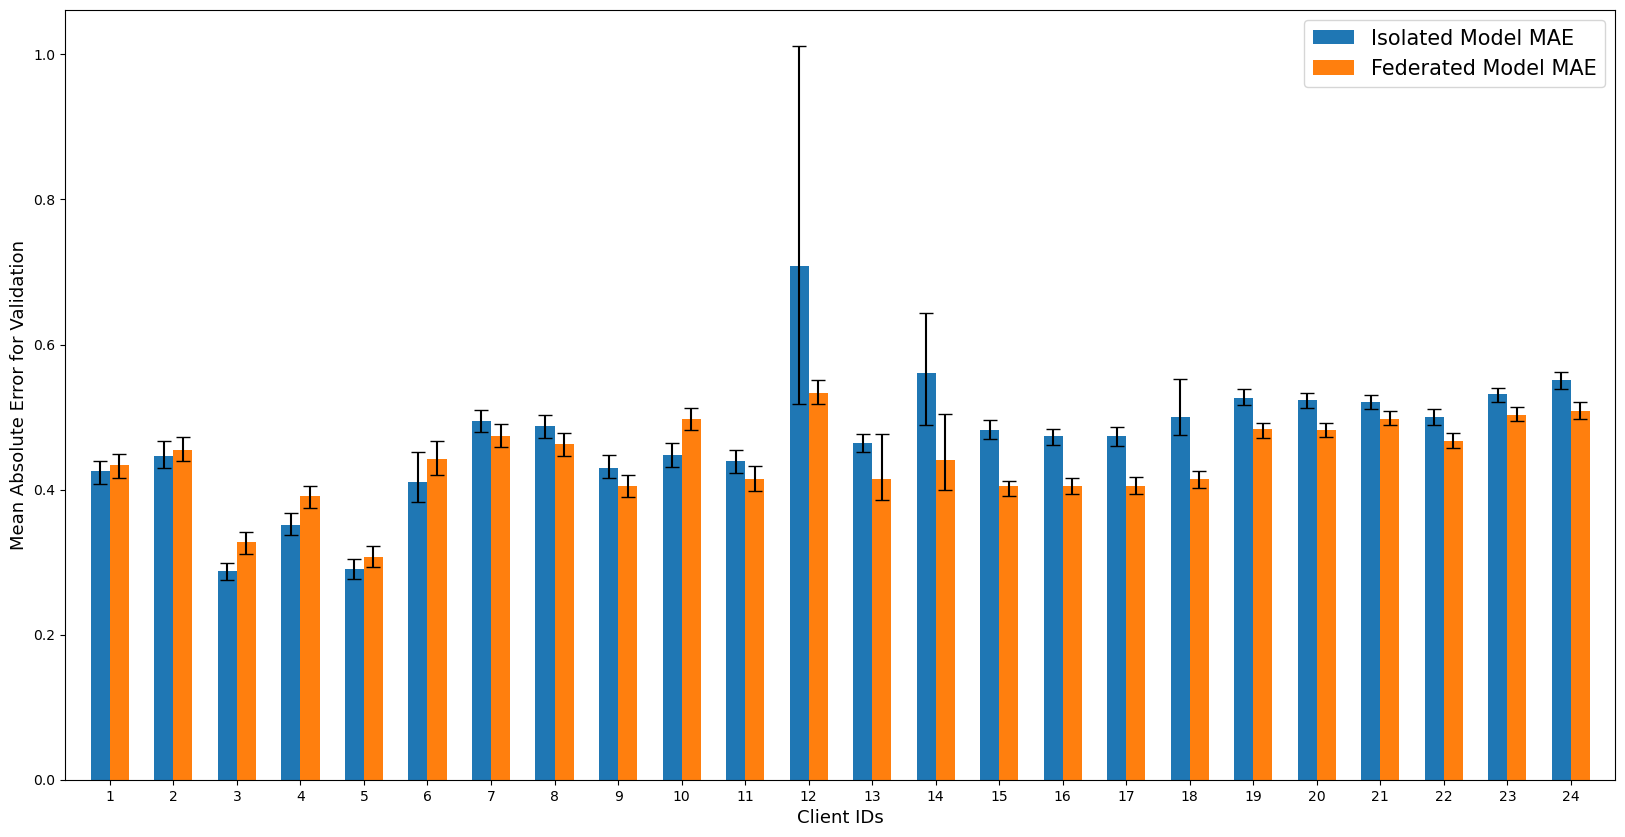

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.3
index = eval_df.index

bar1 = ax.bar(index - bar_width / 2, eval_df['Isolated Average MAE'], bar_width, yerr=[
    (eval_df["Isolated Average MAE"] - eval_df["Isolated MAE lower band"]),
    (eval_df['Isolated MAE upper band'] - eval_df["Isolated Average MAE"])
], capsize=5, label='Isolated Model MAE')

bar2 = ax.bar(index + bar_width / 2, eval_df['Federated Average MAE'], bar_width, yerr=[
    (eval_df["Federated Average MAE"] - eval_df["Federated MAE lower band"]),
    (eval_df['Federated MAE upper band'] - eval_df["Federated Average MAE"])
], capsize=5, label='Federated Model MAE')

ax.set_xlabel('Client IDs', fontdict={'fontsize': 13})
ax.set_ylabel("Mean Absolute Error for Validation", fontdict={'fontsize': 13})
ax.set_xticks(index)
ax.set_xticklabels(eval_df['clients'])
ax.legend(fontsize=15, loc="upper right")

# Adjust the xlim to decrease space at the left and right edges
ax.set_xlim(index[0] - 0.7, index[-1] + 0.7)

plt.show()

## Influence with prediction difference at 500 global rounds

In [6]:
inf_val = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('checkpt/epoch_500/influence/' + str(client)+ '_fedl_global_500.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    inf = influence(global_model,model,val_set)
    inf_val.append(round(inf.item(),4))
   
data = {"client id": client_ids, "inf_val": inf_val}
data = pd.DataFrame(data)
data.to_csv("insights/influence_with_pred_diff_ex1.csv" , index=False)

## Influence with prediction difference at 1 global round and 25 local rounds

In [7]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/epoch_25/1_rounds_25_epochs_per_round/_fedl_global_1_25.pth'))

inf_val_test = []
for client in client_ids:
    model = ShallowNN(features)
    model.load_state_dict(torch.load('checkpt/epoch_25/influence/1_rounds_25_epochs_per_round/' + str(client)+ '_fedl_global_1_25.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    inf = influence(global_model,model,val_set)
    inf_val_test.append(round(inf.item(),4))
    
data_test = {"client id": client_ids, "inf_val": inf_val_test}
data_test = pd.DataFrame(data_test)
data_test.to_csv("insights/influence_with_pred_diff_ex2.csv" , index=False)

## Influence with mae at 1 global round and 25 local rounds

In [8]:
performance_inf = []
for client in client_ids:
    isolated_model = ShallowNN(features)
    isolated_model.load_state_dict(torch.load('checkpt/epoch_500/influence/' + str(client)+ '_fedl_global_500.pth'))
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    _, _ , isolated_mae = evaluate(isolated_model, val_loader, loss_fn)
    _, _ , global_mae = evaluate(global_model,val_loader,loss_fn)
    
    inf = global_mae - isolated_mae
    
    performance_inf.append(round(inf.item(),4))

data = {"client id": client_ids, "inf_val": performance_inf}
data = pd.DataFrame(data)
data.to_csv("insights/influence_with_mae_ex1.csv" , index=False)

## Eccentricity  $\xi^L$ 

$
\begin{equation}\label{eq:Ecc1}
\xi_i = \frac{2\sum_{j=1}^{k}d(\mathcal{H}_{\mu_i}, \mathcal{H}_{\mu_j})}{\sum_{l=1}^{k}\sum _{j=1}^{k} d(\mathcal{H}_{\mu_l}, \mathcal{H}_{\mu_j})},
\end{equation}
$

Where  $\mathcal{H}_{\mu_i}$ is the Hessian matrix of client $i$, and $d(.,.)$ is the Euclidean distance between the Hessian matrices of two clients. 

In [9]:
local_matrix_dict = {
        key: torch.load("hessians/epoch_500/iso/" + str(key) + ".pth")
        for key in client_ids
    }

In [10]:
ecce_dict = hessian_eccentricity(local_matrix_dict, euclidean_distance)
ecc_hessian = {"client id": client_ids, "hess_ecc": list(ecce_dict.values())}
ecc_hessian = pd.DataFrame(ecc_hessian)
ecc_hessian.to_csv("insights/eccentricity_with_hessian_euclidean_with_local_model.csv" , index=False)
ecc_hessian

,client id,hess_ecc
0,0_0,0.0352
1,0_1,0.0356
2,0_2,0.0341
3,0_3,0.0385
4,0_4,0.0373
5,0_5,0.0302
6,1_0,0.0318
7,1_1,0.0389
8,1_2,0.0409
9,1_3,0.0473


## Eccentricity $\xi^G$ 

$
\begin{equation}\label{eq:Ecc1}
\xi_i = \frac{2\sum_{j=1}^{k}d(\mathcal{H}^i_{\mathcal M}, \mathcal{H}^j_{\mathcal M})}{\sum_{l=1}^{k}\sum _{j=1}^{k} d(\mathcal{H}^l_{\mathcal M}, \mathcal{H}^j_{\mathcal M})},
\end{equation}
$

where $\mathcal{H}^i_{\mathcal M}$ is the Hessian matrix of client $i$, and $d(.,.)$ is the Euclidean distance between the Hessian matrices global with respect to the validation dataset of clients $i$. 

In [11]:
global_matrix_dict = {
        key: torch.load("hessians/epoch_500/fed/" + str(key) + ".pth")
        for key in client_ids
    }

In [12]:
ecce_dict_g = hessian_eccentricity(global_matrix_dict, euclidean_distance)
ecc_hessian_g = {"client id": client_ids, "hess_ecc": list(ecce_dict_g.values())}
ecc_hessian_g = pd.DataFrame(ecc_hessian)
ecc_hessian_g.to_csv("insights/eccentricity_with_hessian_euclidean_with_globall_model.csv" , index=False)
ecc_hessian_g

,client id,hess_ecc
0,0_0,0.0352
1,0_1,0.0356
2,0_2,0.0341
3,0_3,0.0385
4,0_4,0.0373
5,0_5,0.0302
6,1_0,0.0318
7,1_1,0.0389
8,1_2,0.0409
9,1_3,0.0473
